# Think Bayes: Chapter 10

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from itertools import product
from IPython.display import display
from scipy import stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

In [2]:
# Read data using Downey's code.
import sys
sys.path.append('ThinkBayes2/code')
import brfss
df = brfss.ReadBrfss(filename='ThinkBayes2/code/CDBRFS08.ASC.gz')
df.dropna(inplace=True)
df.sex.replace({2: 'F', 1: 'M'}, inplace=True)
display(df.head(), df.shape)

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,F,76.363636,185.870345,70.91,157.0
1,65.0,F,72.727273,126.603027,72.73,163.0
3,61.0,M,73.636364,517.926275,73.64,170.0
4,26.0,M,88.636364,1252.624630,88.64,185.0
5,42.0,M,118.181818,415.161314,109.09,183.0


(385974, 6)

In [3]:
grouped = df.groupby('sex')
df_m = grouped.get_group('M')
df_f = grouped.get_group('F')

assert df_m.htm3.isna().any() == False
assert df_f.htm3.isna().any() == False

df_m.shape, df_f.shape

((150321, 6), (235653, 6))

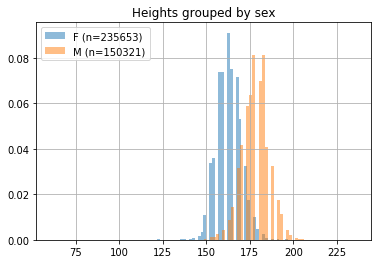

In [4]:
for sex, group in df.groupby('sex'):
    group.htm3.hist(label='%s (n=%d)' % (sex, len(group)), alpha=0.5, bins=100, density=True)
plt.title('Heights grouped by sex')
plt.legend()
plt.show()

## 10.2 Mean and Standard Deviation

Estimate the parameters of a Gaussian distribution: mean $\mu$, standard deviation $\sigma$.

Use classical estimators to find a likely location and spread for $\mu$ and $\sigma$. Then use Bayesian updates to compute a posterior.

If we take a sample of $n$ values, an estimator of $\mu$ is the sample mean $m$ and an estimator of $\sigma$ is the sample standard variance $s$. The standard error of the estimated $\mu$ is $\frac{s}{\sqrt n}$ and standard error of estimated $\sigma$ is $\frac{s}{\sqrt{2(n - 1)}}$.

If you use a naive update scheme implemented in `update()`, you get NaNs from underflow after ~200 updates. To avoid this, use the log-transformed implementation in `logupdate()`. To make the update faster, we can split up the PDF into terms that depend on $\mu$ and terms that depend on $\sigma$. These terms need only be computed once for each value of $\sigma$ and $\mu$. Otherwise they can be cached and re-used. This is implemented in `logupdatefast()` for a > 100x speedup.

Updating hypotheses: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Male mu ~ (178.108967, 0.000480), sigma ~ (8.493392, 0.000000)
Female mu ~ (163.211485, 0.000272), sigma ~ (8.015222, 0.000000)


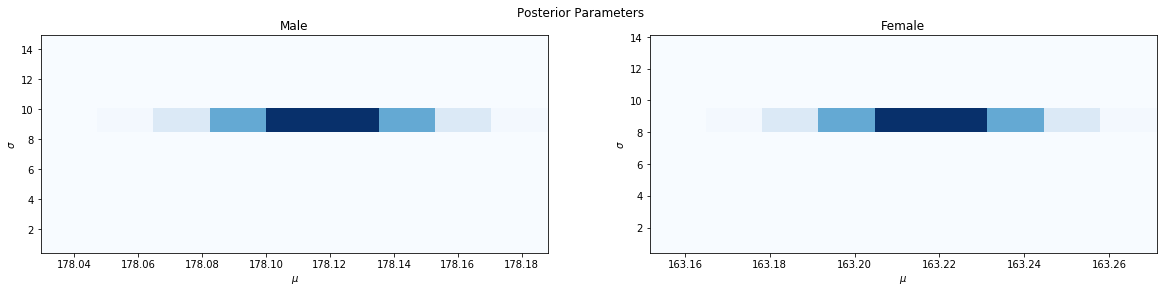

Updating hypotheses: 100%|██████████| 100/100 [00:00<00:00, 7718.20it/s]


Male mu ~ (178.108967, 0.000480), sigma ~ (8.493392, 0.000000)
Female mu ~ (163.211485, 0.000272), sigma ~ (8.015222, 0.000000)


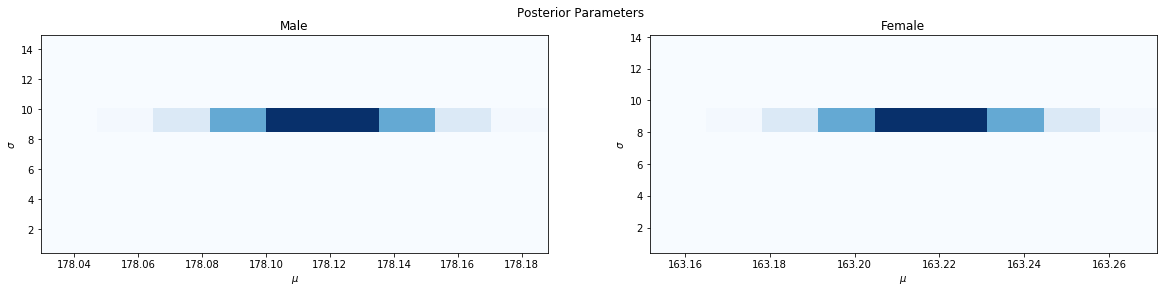

In [25]:
class NormalParameters(mtb.PMF, mtb.Joint):
    
    def __init__(self, mus, sigmas):
        hypos = list(product(mus, sigmas))
        super().__init__(hypos)
        self.mus = mus
        self.sigmas = sigmas

    def update(self, data):
        """Vectorized regular update.
        
        The multiplication of tiny probabilities will cause underflow for len(data) > ~200.
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        for mu, sigma in tqdm(self.hypos, desc='Updating hypotheses'):
            rv = stats.norm(mu, sigma)
            likes = rv.pdf(data)  
            self[(mu, sigma)] *= likes.prod()
        
        return self.normalize()
    
    def logupdate(self, data):
        """Vectorized log-transformed update.
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        for mu, sigma in tqdm(self.hypos, desc='Updating hypotheses'):
            loglikes = stats.norm.logpdf(data, mu, sigma)
            self[(mu, sigma)] += loglikes.sum()
            
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
    def logupdatefast(self, data):
        """Vectorized log-transformed update using dynamic programming (caching).
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        
        # Keep a cache of previously computed values corresponding to each
        # value of sigma and mu.
        cache = dict()
        
        for mu, sigma in tqdm(self.hypos, desc='Updating hypotheses'):
              
            # Show several variations without caching first...
            
            # Compute PDF first, then take log.
            # likes = (1 / np.sqrt(2 * np.pi * sigma**2))
            # likes *= np.exp(-(data - mu)**2 / (2 * sigma**2))
            # loglikes = np.log(likes)
            # loglikes = loglikes[~np.isinf(loglikes)]
            # self[(mu, sigma)] += loglikes.sum()

            # Compute log-likelihood directly.
            # loglikes = -np.log(np.sqrt(2 * np.pi) * sigma)
            # loglikes -= ((data - mu)**2 / (2 * sigma**2))
            # loglikes = loglikes[~np.isinf(loglikes)]
            # self[(mu, sigma)] += loglikes.sum()
            
            # Compute log-likelihood with summation.
            # n = len(data)
            # a = -n * np.log(np.sqrt(2 * np.pi) * sigma)
            # b = np.sum((data - mu)**2) / (-2 * sigma**2)
            # loglike1 = a + b
            # self[(mu, sigma)] += loglike
            
            # Compute log-likelihood with caching.
            # Refer to book for the exact equation.
            # Note that the term a leaves out the constant 1 / (sqrt(2 * \pi) * sigma).
            key = ('s', sigma)
            ab = cache.get(key)
            if not ab:
                a = -len(data) * np.log(sigma)
                b = -1 / (2 * sigma**2)
                cache[key] = (a, b)
            else:
                a, b = ab
                
            key = ('m', mu)
            c = cache.get(key)
            if not c:
                c = np.sum((data - mu) ** 2)
                cache[key] = c
            
            loglike = a + (b * c)
            self[(mu, sigma)] += loglike
        
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
def normal_prior_from_data(heights, n=10, z=4):
    
    m, s = heights.mean(), heights.std()
    
    # Range for $\mu$.
    center = m
    spread = s / np.sqrt(len(heights))
    mus = np.linspace(center - z * spread, center + z * spread, n)
    
    # Range for $\sigma$.
    center = s
    spread = s / np.sqrt(2 * (n - 1))
    sigmas = np.linspace(center - z * spread, center + z * spread, n)
    
    return mus, sigmas

def summarize_parameters(prm_m, prm_f):
    mm, ms = prm_m.marginal(0), prm_m.marginal(1)
    print('Male mu ~ (%.6lf, %.6lf), sigma ~ (%.6lf, %.6lf)' % (
        mm.expectation(), mm.var(), ms.expectation(), ms.var()))

    mm, ms = prm_f.marginal(0), prm_f.marginal(1)
    print('Female mu ~ (%.6lf, %.6lf), sigma ~ (%.6lf, %.6lf)' % (
        mm.expectation(), mm.var(), ms.expectation(), ms.var()))

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 4))
    ax1.pcolormesh(*mtb.Joint.contour_args(prm_m), cmap=matplotlib.cm.Blues)
    ax1.set_xlabel('$\mu$')
    ax1.set_ylabel('$\sigma$')
    ax1.set_title('Male')
    ax2.pcolormesh(*mtb.Joint.contour_args(prm_f), cmap=matplotlib.cm.Blues)
    ax2.set_xlabel('$\mu$')
    ax2.set_ylabel('$\sigma$')
    ax2.set_title('Female')
    plt.suptitle('Posterior Parameters')
    plt.show()
    
prm_m = NormalParameters(*normal_prior_from_data(df_m.htm3))
prm_f = NormalParameters(*normal_prior_from_data(df_f.htm3))
prm_m.logupdate(df_m.htm3.values)
prm_f.logupdate(df_f.htm3.values)
summarize_parameters(prm_m, prm_f)

prm_m = NormalParameters(*normal_prior_from_data(df_m.htm3))
prm_f = NormalParameters(*normal_prior_from_data(df_f.htm3))
prm_m.logupdatefast(df_m.htm3.values)
prm_f.logupdatefast(df_f.htm3.values)
summarize_parameters(prm_m, prm_f)